_This notebook contains code and comments from Section 1.4 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 1.4 A Simple Model Averaging Ensemble

We will build our first ensemble with model averaging for a regression task on the classic benchmark **Friedman-1**. 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_friedman1
X, y = make_friedman1(n_samples=500, n_features=15, noise=0.3, random_state=23)
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25)

Now, we learn several different different regressors (mostly using default settings).

**Listing 1.1**: Training diverse base estimators

In [2]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

estimators = {'krr': KernelRidge(kernel='rbf', gamma=0.25), 
              'svr': SVR(gamma=0.5),
              'dtr': DecisionTreeRegressor(max_depth=3),
              'knn': KNeighborsRegressor(n_neighbors=4),
              'gpr': GaussianProcessRegressor(alpha=1e-1),
              'mlp': MLPRegressor(alpha=25, max_iter=10000)}

for name, estimator in estimators.items():
    print('Training {0}'.format(name))
    estimator = estimator.fit(Xtrn, ytrn)

Training krr
Training svr
Training dtr
Training knn
Training gpr
Training mlp


Once we have trained the individual base estimators, we can make individual predictions and then aggregate them into a final **ensemble prediction**. As this is a regression problem, the aggregator is the average, and thus, this approach is known as model averaging.

**Listing 1.2**: Aggregating base estimator predictions 

In [3]:
import numpy as np
n_estimators, n_samples = len(estimators), Xtst.shape[0]

y_individual = np.zeros((n_samples, n_estimators))
for i, (model, estimator) in enumerate(estimators.items()):
    y_individual[:, i] = estimator.predict(Xtst)
y_final = np.mean(y_individual, axis=1)

One way to understand the benefits of ensembling is if we look at all possible combinations of models for predictions. That is, we look at the performance of one model at a time, then all possible ensembles of two models (there are 15 such combinations), then all possible ensembles of three models (there are 20 such combinations) and so on. For ensemble size 1 to 6, we plot the test set performances of all these ensemble combinations.

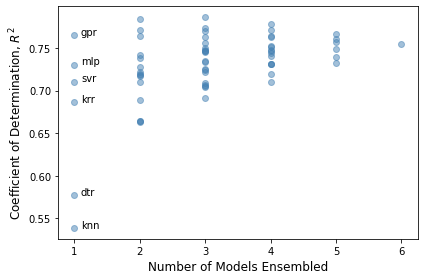

In [4]:
from itertools import combinations
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

models = list(estimators.keys())
combo_mean = np.zeros((len(estimators), ))
combo_std = np.zeros((len(estimators), ))

fig = plt.figure();

for n_ensemble in range(len(estimators)):
    # Get all possible combinations of models of length n_ensemble
    combos = combinations(estimators, n_ensemble + 1)
        
    # Get the average of individual predictions for each combination
    averaged_predictions = [np.mean(np.array([y_individual[:, models.index(e)] for e in list(c)]), axis=0) for c in combos]
    averaged_r2 = [r2_score(ytst, ypred) for ypred in averaged_predictions]
    
    n_combos = len(averaged_r2)
    
    plt.scatter(np.full((n_combos, ), n_ensemble + 1), averaged_r2, color='steelblue', alpha=0.5)
    combo_mean[n_ensemble] = np.mean(averaged_r2)
    combo_std[n_ensemble] = np.std(averaged_r2)
    
    if n_ensemble == 0:
        for r, name in zip(averaged_r2, estimators):
            plt.text(1.1, r, name)
            
plt.xlabel('Number of Models Ensembled', fontsize=12);
plt.ylabel('Coefficient of Determination, $R^2$', fontsize=12);
fig.tight_layout()

# plt.savefig('./figures/CH01_F08_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');
# plt.savefig('./figures/CH01_F08_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight');

As we aggregate more and more models, we see that the ensembles generalize increasingly better. The most striking result of our experiment, though, is that the performance of the ensemble of all 6 estimators is often (across several runs) better than the performances of each individual estimator.

Finally, what of fit vs. complexity? It is difficult to characterize the complexity of the ensemble, as different types of estimators in our ensemble have different complexities. However, we can characterize the variance of the ensemble.

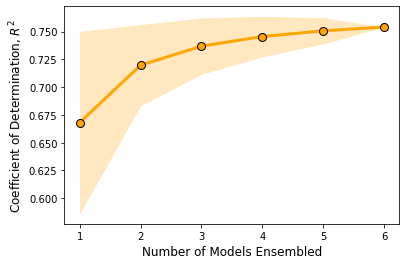

In [5]:
fig = plt.figure()
plt.fill_between(np.arange(1, len(estimators) + 1), 
                combo_mean - combo_std, combo_mean + combo_std, color='orange', alpha=0.25, linewidth=0);
plt.plot(np.arange(1, len(estimators) + 1), combo_mean, marker='o', color='orange', markersize=8, 
        markeredgecolor='k', linewidth=3);
plt.xlabel('Number of Models Ensembled', fontsize=12);
plt.ylabel('Coefficient of Determination, $R^2$', fontsize=12);

# plt.savefig('./figures/CH01_F09_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');
# plt.savefig('./figures/CH01_F09_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight');

As ensemble size increases, the variance of the ensemble decreases! This is a consequence of model aggregation or averaging. We know that averaging “smooths out the rough edges”. The overall ensemble is more robust to mistakes, and unsurprisingly, generalizes better than any single base estimator.